In [56]:
# Load the lightning model from checkpoint

import pytorch_lightning as pl
import torch
import numpy as np
from src.failure_model import ToxicClassifier
from src.datasets import PromptOnlyDataset, PropDataset

cal_prompts = PromptOnlyDataset("data/rtp/split_1_0.5_0.1_0.2_0.2/cal.pkl")

# cal_prompts.data = cal_prompts.data[:100]

# Examine the model weights in the checkpoint before loading
checkpoint = torch.load("saved/MS_RTP_ModernBERT/lightning_logs/version_8/checkpoints/epoch=1-step=994.ckpt")

model = ToxicClassifier.load_from_checkpoint("saved/Prop_RTP_ModernBERT/lightning_logs/version_26/checkpoints/epoch=4-step=495.ckpt")

taus = torch.tensor(np.logspace(-3, 0, 20))
# Get the index closest to 0.1
idx = (taus - 0.1).abs().argmin()
model.set_taus(taus)
model.eval()

trainer = pl.Trainer()
# pred = trainer.predict(model, cal_prompts)

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [57]:
# Create generation and rating backends
from src.rating.detoxify import DetoxifyRater
from src import utils
from src.generation.vanilla_model import VanillaGenerator
from src.survival_runner import (
    SurvivalRunner,
    SurvivalResult,
    default_toxicity_func,
    default_text_prep_func,
)

rater_backend = DetoxifyRater(
    model_type="original",
    amp=True,
)

hf_key = utils.api_key_from_file("HF_KEY.txt")

generator_backend = VanillaGenerator(
    model_name="meta-llama/Llama-3.2-3B",
    hub_token=hf_key,
    max_input_tokens=40,
    max_output_tokens=30,
    torch_dtype=torch.bfloat16,
    # attn_implementation="flash_attention_2",
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

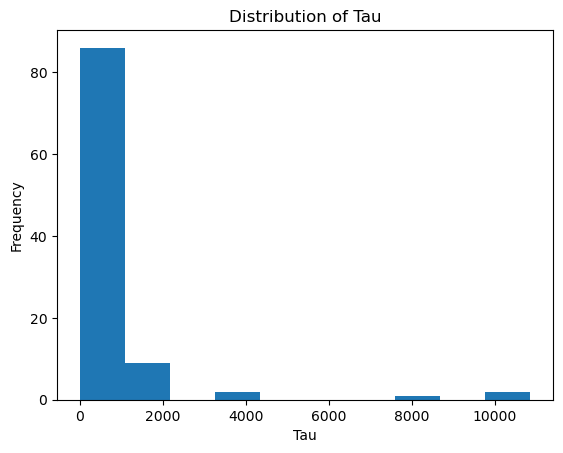

In [58]:
from matplotlib import pyplot as plt

# Plot the distribution of [item['tau'][idx].item() for item in pred]
plt.hist([item['tau'][idx].item() for item in pred])
plt.xlabel("Tau")
plt.ylabel("Frequency")
plt.title("Distribution of Tau")
plt.show()

In [59]:
# Force reimport
import importlib
import src.conformal
importlib.reload(src.conformal)
from src.conformal import conformalize

trainer = pl.Trainer()
target_taus = torch.tensor([0.1])
canidate_taus = torch.tensor(np.logspace(-5, -1, 200))

tau_hat, max_est, q_hat = conformalize(trainer=trainer, model=model, target_taus=target_taus, canidate_taus=canidate_taus, X=cal_prompts, generation_backend=generator_backend, rating_backend=rater_backend, 
                              budget_per_sample=200, share_budget=True, min_sample_size=0.05, text_prep_func=lambda gen: gen.prompt + gen.output)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

tensor([1.0000e-05], dtype=torch.float64)
1000
Average prediction for tau=tau_hat: tensor(5.2700, dtype=torch.float64)
Average prediction for tau=0.1: tensor(540.3800, dtype=torch.float64)


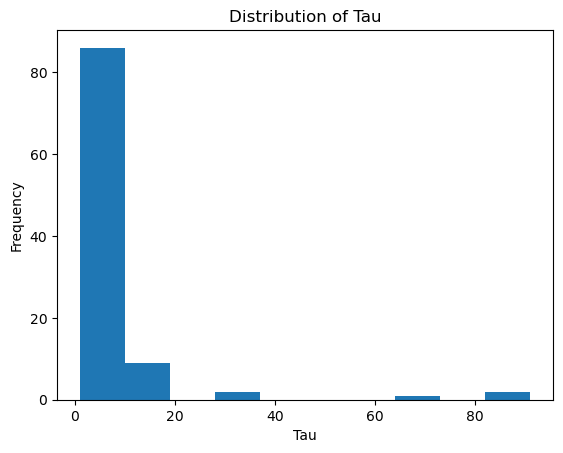

In [ ]:
print(tau_hat)
print(max_est)
# Print the average prediction for tau=tau_hat
idx_tau_hat = (taus - tau_hat).abs().argmin()
print("Average prediction for tau=tau_hat:", torch.mean(torch.stack([item['tau'][idx_tau_hat] for item in pred])))
print("Average prediction for tau=0.1:", torch.mean(torch.stack([item['tau'][idx] for item in pred])))

# Plot the distribution of [item['tau'][idx_tau_hat].item() for item in pred]
plt.hist(q_hat)
plt.xlabel("Tau")
plt.ylabel("Frequency")
plt.title("Distribution of Tau")
plt.show()